This notebook explores the effects of the readout function on wiring diagrams implementing Algebraic Dynamics. It can be used to simplify a wiring diagram and can affect multi-variable communication.

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
);

# Part 1 - Insolated box

Consider a single box with an arbitrary number of states. It has no inputs and no outputs. How must this system be constructed to compile reasonable results?  

The readout function defines the output of a box. It takes the state of its box as an input, and transforms this state into a vector. This vector can have any dimensions. This can be larger or smaller than the state itself. For more information see this link:  

https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/

In [3]:
# Constants
k1 = 1;      
k2 = 1;

# State equation
equation(u, x, p, t) = [ u[2], -k1*u[1] - k2*u[2] ]; 

# Empty readout funtion - No outputs
readout(u) = [];

Assume the diagram is closed. The box is also closed as it has to inputs or outputs.

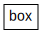

In [4]:
# Empty diagram
diagram = WiringDiagram( [], [] ); 

# No inputs or outputs
box = add_box!( diagram, Box(:box, [], []) );

show_diagram(diagram)

In this case there are two states, yet due to the box diagram one knows there are zero outputs and zero inputs.

In [5]:
box_machine = ContinuousMachine{Float32}( 0,			# Inputs
                                          2,			# States
                                          0, 		    # Outputs
                                          equation,   # Input function
                                          readout);    # State is transformed into the state

net_machine = oapply(diagram, [box_machine])

ContinuousMachine(ℝ^2 × ℝ^0 → ℝ^2)

This system will compile so long as the <i>number of outputs of the readout function</i> equals the number of <i>outputs of the box</i>.  

r(u) = readout(state_u) = func(u1,u2,u3,u4...uN) means that N_outputs = N_readout

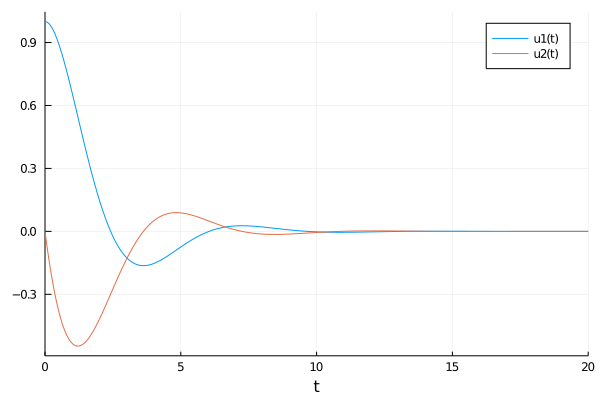

In [6]:
u_init = [1,0];
t_span = (0, 20); 

sol = solve( ODEProblem(net_machine, u_init, t_span), alg_hints=[:stiff] );
plot(sol)

# Part 2 - Single variable communication

The readout function can be used to return a vector that is smaller than the state. This allows one to reduce the number of wires between boxes.  

Consider a system of two springs that do not communicate. The position of the 1rst spring dictates the target position of the 2nd.

In [7]:
#- Constants
k1 = 1;    # Spring  
k2 = 1;    # Damper
 
#- Box equations: u' = f(u, x, t, p)

# State vector:
# u[1] = u
# u[2] = u'
# u[3] = u'' 
# etc

equation1(u, x, p, t) = [ u[2], -k1*u[1] - k2*u[2] ]; 
equation2(u, x, p, t) = [ u[2], -k1*( u[1] - x[1] ) - k2*u[2] ]; 

#- Output functions: r(u) = vector 
# x[n] = r[n]

# Note: The readout functions need to output a vector. This is the format expected by the subsequent functions. 
#       Even a single value must be surrounded by brackets. 

readout1(u) = [ u[1] ];     # Box1 outputs the position 
readout2(u) = [];           # Box2 has no outputs, empty readout function

The wiring diagram is composed of two boxes with a single wire transmitting information. This wire transfers a single scalar value.

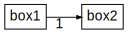

In [8]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], []) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1) 
])

show_diagram(diagram)

As the boxes are communicating via a single wire, this dictates the parameters of the state machines. Box1 sends the output of readout1 to the input of box 2.

In [9]:
# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float32}( 0, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float32}( 1, 2, 0, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine])

ContinuousMachine(ℝ^4 × ℝ^0 → ℝ^4)

This system compiles and behaves as expeted. Even though the boxes have two states one 1 value is transmitted. The wire transmits a single scalar value.

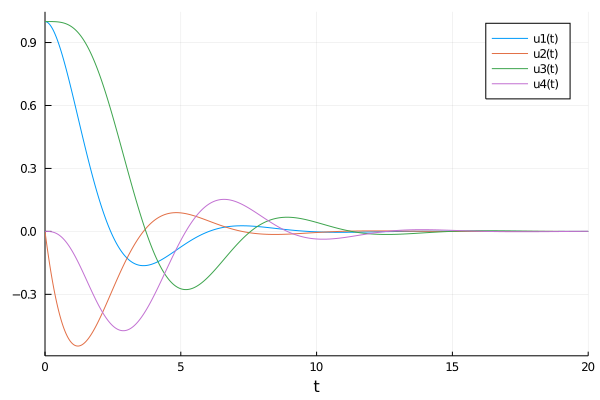

In [10]:
# Initial conditions:
u_init = [1, 0, 1, 0];
t_span = (0, 20); 

# Solve system:
sol = solve( ODEProblem(net_machine, u_init, t_span), alg_hints=[:stiff] );
plot(sol)

# Part 3 - Attempt at multi-variate communiation

Given the readout function is defined by the user, there may be a way to construct the output so multiple values are sent on a single wire. Consider the above example but now the velocity of the box is received by the 2nd box.

One idea is to have the readout function return a multidimensional array. The first dimension determines the wire, and the 2nd dimension determines the value carried by said wire.

In [28]:
#- Constants
k1 = 1;     
k2 = 1;    
 
# State Functions 
equation1(u, x, p, t) = [ u[2], -k1*u[1] - k2*u[2] ]; 
equation2(u, x, p, t) = [ u[2], -k1*( u[1] - x[1][1] ) - k2*u[2] ]; 

# Output functions: r(u) 
readout1(u) = [ [ u[1], u[2] ] ];  # A vector of arrays. Each vector element is a wire, each array element is a value.     
readout2(u) = [[]];           

The state machines should remain unchanged as they are determined by the boxes and these have not changed.

In [12]:
# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float32}( 0, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float32}( 1, 2, 0, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine]);

Unfortunately this system does not compile. It seems the ODE solver expects a float, yet the value being read is an array.  

This means the readout function must output an array of <i>floats</i> to succesfully compile. Still, there may be other structures it can return that leads to compilation.

In [19]:
u_init = [1 ,0, 0, 0];
t_span = (0, 20); 

# This seems to be convertible into ODE form.
data = ODEProblem(net_machine, u_init, t_span)

# Attempt solving system
try 
    sol = solve( data, alg_hints=[:stiff] )
catch error
    print(error)
    print("\n\n Message w/o error block: \n")
    print( "MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float32" );
end

MethodError(convert, (Float32, [1.0, 0.0]), 0x0000000000006e54)

 Message w/o error block: 
MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float32

# Part 4 - Changing machine type

The continuous machines use a specified data type. This type has to concide with each element of the output array of the readout function.  

It may be possible to manipulate this property to transmit an array through a single wire. This example investigates this possibility. For simplicity consider a single box with two states.

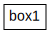

In [33]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:out]) );

show_diagram(diagram)

With such a simple diagram, whatever errors occur will be due to the data type. Assume the box contains two states like before.

In [34]:
#- Constants
k1 = 1;     
k2 = 1;    
 
# State Functions 
equation1(u, x, p, t) = [ u[2], -k1*u[1] - k2*u[2] ]; 

# Output functions: r(u) 
readout1(u) = [ [ u[1], u[2] ] ];  # A vector of arrays. Each vector element is a wire, each array element is a value.        

Let us see if this code compiles. The logic is that each wire carries of type data_type that must match the output of the readout function.

In [35]:
# Type:
data_type = typeof( [1.0, 1.0] );

# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{data_type}( 0, 2, 1, equation1, readout1 );      

Unfortunately this does not work. From the error, it seems the continousMachine does not support arrays as a datatype. However, scalar types such as Float or Int seem to work. It seems to fail at the composition step.

In [36]:
# Compose
net_machine = oapply( diagram, [box1_machine] );

LoadError: [91mMethodError: no method matching zero(::Type{Array{Float64,1}})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  zero([91m::Type{Missing}[39m) at missing.jl:103[39m
[91m[0m  zero([91m::Type{Dates.DateTime}[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Dates\src\types.jl:404[39m
[91m[0m  zero([91m::Type{Symbolics.TermCombination}[39m) at C:\Users\bobby\.julia\packages\Symbolics\JhAD8\src\linearity.jl:67[39m
[91m[0m  ...[39m

This error is also present in the case of two boxes. In this case the error also occurs at the composition step.

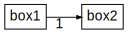

In [37]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], []) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1) 
])

show_diagram(diagram)

In [38]:
# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{ Array{Float64,1} }( 0, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 0, equation2, readout2 );  

In [40]:
# Compose
net_machine = oapply( diagram, [box1_machine, box2_machine] );

LoadError: [91mMethodError: no method matching oapply(::WiringDiagram{Any,Any,Any,Any}, ::Array{ContinuousMachine,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  oapply(::WiringDiagram, [91m::Array{Machine,1}[39m) where {T, Machine<:AbstractMachine{T}} at C:\Users\bobby\.julia\packages\AlgebraicDynamics\QtWNA\src\dwd_dynam.jl:215[39m
[91m[0m  oapply(::WiringDiagram, [91m::AbstractMachine[39m) at C:\Users\bobby\.julia\packages\AlgebraicDynamics\QtWNA\src\dwd_dynam.jl:262[39m
[91m[0m  oapply(::WiringDiagram, [91m::AbstractDict[39m) at C:\Users\bobby\.julia\packages\AlgebraicDynamics\QtWNA\src\dwd_dynam.jl:270[39m